<a href="https://colab.research.google.com/github/lvpineres/Pneumonia_prediction_final_project/blob/main/Big_Data_first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection Using PySpark
Pneumonia is a serious lung infection that can be life-threatening if not diagnosed and treated promptly. In this project, we aim to build a machine learning pipeline using PySpark to classify chest X-ray images into categories, such as "Normal" and "Pneumonia." PySpark, a powerful distributed computing framework, allows us to efficiently preprocess large datasets and train scalable machine learning models. By leveraging advanced classification algorithms, we will compare the performance of different models, including Logistic Regression, Random Forest, Gradient-Boosted Trees, and Support Vector Machines (SVM). The project demonstrates the full workflow, from data preprocessing and model training to evaluation and visualization, showcasing how PySpark can be used for large-scale image-based machine learning tasks.

Initialize the Spark session and configure memory for efficient processing

In [ ]:
!pip install -q pyspark

appname = "Pneumonia Prediction 2"

from pyspark.sql import SparkSession
# Before starting the SparkSession
# Increase the driver memory
spark = SparkSession.builder.appName(appname) \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

Download kaggle data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:28<00:00, 27.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
import os

# Check the folder structure
base_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2"
for root, dirs, files in os.walk(base_path):
    print(f"Root: {root}, Directories: {dirs}, Files: {len(files)}")

Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2, Directories: ['chest_xray'], Files: 0
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray, Directories: ['train', 'val', 'test', 'chest_xray', '__MACOSX'], Files: 0
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train, Directories: ['NORMAL', 'PNEUMONIA'], Files: 0
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL, Directories: [], Files: 1341
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA, Directories: [], Files: 3875
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val, Directories: ['NORMAL', 'PNEUMONIA'], Files: 0
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/NORMA

Load the chest X-ray dataset and preprocess images (resize, grayscale, and flatten)

Resize images to 128x128, convert to grayscale, and flatten into feature vectors

Store the label (e.g., 'NORMAL', 'PNEUMONIA') along with the processed features

In [ ]:
from pyspark.sql import Row
from PIL import Image
import numpy as np
import os

def load_images_with_labels(folder):
    data = []
    for subfolder in os.listdir(folder):
        label_path = os.path.join(folder, subfolder)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                try:
                    # Open and preprocess the image
                    img = Image.open(file_path).convert("L")  # Convert to grayscale
                    img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img).flatten().tolist()  # Flatten to a 1D array
                    data.append(Row(label=subfolder, features=img_array))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return data

Split the dataset into training and testing sets

In [ ]:
# Paths
train_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train"
test_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test"
val_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val"

# Load data
train_data = load_images_with_labels(train_path)
test_data = load_images_with_labels(test_path)
val_data = load_images_with_labels(val_path)

# Create PySpark DataFrames
train_df = spark.createDataFrame(train_data)
test_df = spark.createDataFrame(test_data)
val_df = spark.createDataFrame(val_data)

# Show a sample of the data
train_df.show(5)

+------+--------------------+
| label|            features|
+------+--------------------+
|NORMAL|[82, 92, 90, 104,...|
|NORMAL|[24, 31, 43, 51, ...|
|NORMAL|[31, 40, 55, 63, ...|
|NORMAL|[41, 49, 57, 62, ...|
|NORMAL|[133, 117, 108, 1...|
+------+--------------------+
only showing top 5 rows



Converts label string to numerical value

In [ ]:
from pyspark.ml.feature import StringIndexer

# Convert labels to numeric
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
train_df = label_indexer.fit(train_df).transform(train_df)
test_df = label_indexer.fit(test_df).transform(test_df)
val_df = label_indexer.fit(val_df).transform(val_df)

# Show the processed DataFrame
train_df.select("features", "label", "label_index").show(5)

+--------------------+------+-----------+
|            features| label|label_index|
+--------------------+------+-----------+
|[82, 92, 90, 104,...|NORMAL|        1.0|
|[24, 31, 43, 51, ...|NORMAL|        1.0|
|[31, 40, 55, 63, ...|NORMAL|        1.0|
|[41, 49, 57, 62, ...|NORMAL|        1.0|
|[133, 117, 108, 1...|NORMAL|        1.0|
+--------------------+------+-----------+
only showing top 5 rows



Convert the feature arrays into DenseVectors for compatibility with PySpark MLlib

In [ ]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# UDF to convert array to DenseVector
def to_dense_vector(array):
    return Vectors.dense(array)

# Define the UDF with VectorUDT
to_dense_vector_udf = udf(to_dense_vector, VectorUDT())

# Apply the UDF to convert the features column
train_df = train_df.withColumn("features_vector", to_dense_vector_udf(train_df["features"]))
test_df = test_df.withColumn("features_vector", to_dense_vector_udf(test_df["features"]))
val_df = val_df.withColumn("features_vector", to_dense_vector_udf(val_df["features"]))

Train a Logistic Regression model on the preprocessed training dataset

Logistic Regression is used as a baseline for classification

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Initialize the logistic regression model
lr = LogisticRegression(featuresCol="features_vector", labelCol="label_index", maxIter=10)

# Train the logistic regression model
lr_model = lr.fit(train_df)

# Make predictions
lr_predictions = lr_model.transform(test_df)

# Evaluate
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

Logistic Regression Accuracy: 0.7772435897435898


Train a Random Forest model for classification

Random Forest is robust and handles non-linear patterns well

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize the Random Forest model
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="label_index", numTrees=100)

# Train the Random Forest model
rf_model = rf.fit(train_df)

# Make predictions
rf_predictions = rf_model.transform(test_df)

# Evaluate
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.7483974358974359


Train a Gradient-Boosted Trees model for classification

GBT is a powerful boosting algorithm that often yields high accuracy

In [ ]:
from pyspark.ml.classification import GBTClassifier

# Initialize the Gradient-Boosted Trees model
gbt = GBTClassifier(featuresCol="features_vector", labelCol="label_index", maxIter=50)

# Train the GBT model
gbt_model = gbt.fit(train_df)

# Make predictions
gbt_predictions = gbt_model.transform(test_df)

# Evaluate
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy}")

Gradient-Boosted Trees Accuracy: 0.7259615384615384


Train a Support Vector Machine (SVM) model for binary classification

SVM is effective for high-dimensional datasets like image data

In [ ]:
from pyspark.ml.classification import LinearSVC

# Initialize the Support Vector Machine model
svm = LinearSVC(featuresCol="features_vector", labelCol="label_index", maxIter=10)

# Train the SVM model
svm_model = svm.fit(train_df)

# Make predictions
svm_predictions = svm_model.transform(test_df)

# Evaluate
svm_accuracy = evaluator.evaluate(svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7964743589743589


Store the names of the models and their respective accuracies for comparison

Plot the accuracies of the trained models using a bar chart

Visualize the model performance to identify the best classifier

Add data labels to the chart for clarity

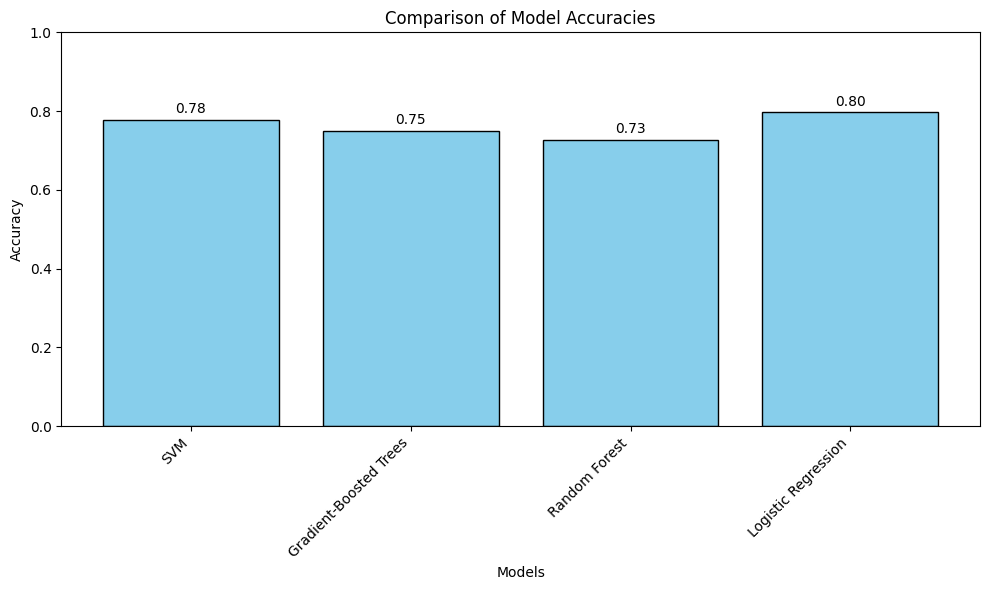

SVM Accuracy: 0.7772
Gradient-Boosted Trees Accuracy: 0.7484
Random Forest Accuracy: 0.7260
Logistic Regression Accuracy: 0.7965


In [ ]:
import matplotlib.pyplot as plt

# Model names as strings
model_names = ["SVM", "Gradient-Boosted Trees", "Random Forest", "Logistic Regression"]

# Numeric accuracies (remove the text labels)
model_accuracies = [lr_accuracy,rf_accuracy,gbt_accuracy,svm_accuracy]

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color="skyblue", edgecolor="black")
plt.ylim(0, 1)  # Accuracy range (0-1)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.title("Comparison of Model Accuracies")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility

# Add data labels to each bar
for i, accuracy in enumerate(model_accuracies):
    plt.text(i, accuracy + 0.01, f"{accuracy:.2f}", ha="center", va="bottom")

# Show the plot
plt.tight_layout()
plt.show()

# Print the accuracies for reference
for name, acc in zip(model_names, model_accuracies):
    print(f"{name} Accuracy: {acc:.4f}")

###BigDL ATTEMPT

In [ ]:
from bigdl.dllib.feature.image import ImageSet

# Convert DataFrame to ImageSet
train_imageset = ImageSet.read(train_path, sc=spark.sparkContext)
test_imageset = ImageSet.read(test_path, sc=spark.sparkContext)
val_imageset = ImageSet.read(val_path, sc=spark.sparkContext)

In [ ]:
from bigdl.dllib.nn.layer import Sequential
from bigdl.dllib.nn.layer import SpatialConvolution, SpatialMaxPooling, ReLU, View, Linear, SoftMax

model = Sequential()
model.add(SpatialConvolution(3, 64, 3, 3, 1, 1))
model.add(ReLU())
model.add(SpatialMaxPooling(2, 2, 2, 2))
model.add(View([-1, 64 * 112 * 112]))
model.add(Linear(64 * 112 * 112, 128))
model.add(ReLU())
model.add(Linear(128, 2))
model.add(SoftMax())

In [ ]:
classifier = NNClassifier(model, CrossEntropyCriterion(), [8]) \
    .setOptimMethod(Adam()) \
    .setBatchSize(32) \
    .setMaxEpoch(150)

In [ ]:
#Resize images
from bigdl.dllib.feature.image.transform import Resize, ChannelNormalize, MatToTensor, FeatureToSample, Pipeline

# Define image transformation pipeline for BigDL 0.14.0
transform_pipeline = Pipeline([
    Resize(224, 224),  # Resize images
    ChannelNormalize(0.5, 0.5, 0.5, 0.5),  # Normalize
    MatToTensor(format="NHWC"),  # Convert to tensor
    FeatureToSample()
])

# Apply transformations to ImageSet
train_imageset = transform_pipeline(train_imageset)
test_imageset = transform_pipeline(test_imageset)
val_imageset = transform_pipeline(val_imageset)


The BigDL shows several inconvinience along the attemps, it was not possible to obtain a great success and this is mainly related to the incompatibility between the PySpark DataFrame format and BigDL’s ImageSet expectations. Chest X-ray data set contain imagen that must be convert into RDD of Imagefeature trough Transformation Pipeline in order to resize, however it was failing not matter all the methods we used likely due to version mismatches, also another issue we encounter is that even we generate our pysoark dataframe with label it was not recognize for BigDL model. There are key recommendation that can be applied for future image dataset project including testing update version and manually extracting image paths, raw data, and labels from PySpark DataFrame.

# Conclusion
In this project, we built a machine learning pipeline using PySpark to classify chest X-ray images into categories, such as detecting pneumonia. First, we initialized a PySpark SparkSession and loaded the dataset, preprocessing the images by resizing them to a fixed size (128x128), converting them to grayscale, and flattening them into feature vectors. We ensured the data was correctly formatted with labels indexed as numeric values and features represented as Spark DenseVector objects. Next, we trained several machine learning models, including Logistic Regression, Random Forest, Gradient-Boosted Trees, and Support Vector Machines (SVM), using the features_vector as input features and label_index as target labels. For each model, we evaluated its performance on a test dataset using the MulticlassClassificationEvaluator to calculate accuracy. Finally, we visualized the accuracies of all models using a bar chart created with Matplotlib, enabling us to compare their performance and choose the best-performing model. This end-to-end workflow demonstrates how to use PySpark for distributed data processing and machine learning on image datasets, leveraging its scalability and flexibility to handle large-scale data efficiently.

#Cross-evaluation of all members of the group
* Nathan Junod - 10
* Laura Piñeres-Santos - 10
* Alejandro Rodriguez Sancho - 10